## Meta Analysis

### 1. Create Dataset
If you already have a dataset, you do not have to follow this section, we are going to show how the simulation will be done.

In [94]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('pwd'))))))

In [95]:
import argparse
import pandas as pd
import math
import numpy as np
import matplotlib.pylab as plt
import numpy as np
import argparse
from src.Senstivity import Sensitivity
import copy
import math
from tqdm import tqdm
from src.Util import Permutator
import time
from tqdm import tqdm
import os
#import dirichlet
from tqdm import tqdm
parser = argparse.ArgumentParser(description='Args Sparse Simulation')
parser.add_argument('--p_num', type=int, default=1000, help='num ber of permutation')
parser.add_argument('--x_grid_start',type=int, default=1,help='start of the x-axis')
parser.add_argument('--x_grid_end',type=int, default=20,help='end of the x-axis')
parser.add_argument('--same_ratio',type=int, default=90,help='Difference ratio for each group') ## only can choose 50,90, 100
parser.add_argument('--interval',type=float,default=0.1,help='interval for x-axis' )
parser.add_argument('--epsilon',type=float,default=0.0001,help='to_avoid zero division')
parser.add_argument('--repeat_num',type=int, default=1, help='to see the mean and sd for the p-value after repeated permutation')
parser.add_argument('--num_feature',type=int,default=100,help='number of feature to simulate') ## only can choose n=100, 300, 600
parser.add_argument('--predefined',type=bool,default=False,help='False if there is predefined meta analysis')
parser.add_argument('--theta',type=float,default=0.0001,help='theta value for dirichlet')
parser.add_argument('--num_samples',type=int,default=50,help='number of samples')
args, _ = parser.parse_known_args()

In [96]:

import pandas as pd
import numpy as np
def seed_everything(seed):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False
    # torch.use_deterministic_algorithms(True)



seed=1337
seed_everything(seed)

In [97]:
seed_everything(seed)

beta=0.8

# randomly select the number of microiomes to change the ratio
num_microbiomes_to_change=200
# sort

start_idx=0
end_idx=10
sort_option=True



otu=pd.read_csv("../../Example/Meta_Analysis_Example/throat_otu.csv")

# drop the first column
otu=otu.drop(columns=['Unnamed: 0'])

#dive each row by sum of the row
otu=otu.div(otu.sum(axis=1), axis=0)


ratio=otu.mean()

#print(c)

#otu['x']
# drop three most abundant species

#sort 
# otu=otu.sort_values(by='x',ascending=False)
# #otu=otu.iloc[3:]

#sort ratio
ratio=ratio.sort_values(ascending=False)
ratio=ratio.iloc[3:]

# # divide by sum of the row
# ratio=otu['x']/otu['x'].sum()

#
# randomly select the microbiomes to change the ratio
ratio=ratio.to_numpy()
#ratio=np.random.dirichlet(ratio*100000,size=1)[0]
if sort_option ==False:
    # sort ratio
    np.random.shuffle(ratio)


#theta_1=0.000002 # overdispersion parameter
#num_samples=100 # number of samples.  this will be a major paramter. 

#ratio=np.random.dirichlet(ratio*10000,size=1)[0]

import copy

ratio_fixed_1=copy.deepcopy(ratio[:start_idx])
ratio_to_change=copy.deepcopy(ratio[start_idx:end_idx])
#ratio_to_change
ratio_fixed_2=copy.deepcopy(ratio[end_idx:])

decreased=ratio_to_change[:int(len(ratio_to_change)/2)]-ratio_to_change[:int(len(ratio_to_change)/2)]*beta

ratio_change_first_half=ratio_to_change[:int(len(ratio_to_change)/2)]-decreased
ratio_second_half=copy.deepcopy(ratio_to_change[int(len(ratio_to_change)/2):])
increased=np.zeros(len(ratio_second_half))
sum_ratio_second_half=ratio_second_half.sum()   

for i in range(len(ratio_second_half)):

    additive=(decreased.sum()*0.5)/len(ratio_second_half)
    proportion=(decreased.sum()*0.5)*ratio_second_half[i]/sum_ratio_second_half
    increased[i]=additive+proportion

# distribute the increased ratio to the second half with equivalent to 

ratio_second_half=ratio_second_half+increased

g1_param=copy.deepcopy(ratio)
g_first_half=np.concatenate((ratio_fixed_1,ratio_change_first_half,ratio_second_half))
g2_param=np.concatenate((g_first_half,ratio_fixed_2))


theta_2=0.0001 # overdispersion parameter

ovedispersion=(1-theta_2)/theta_2
# g1_param=g1_param+1e-10
# g2_param=g2_param+1e-10

g1=np.random.dirichlet(g1_param*ovedispersion,size=args.num_samples)
g2=np.random.dirichlet(g2_param*ovedispersion, size=args.num_samples)
# s
#create count poisson
g1_count_total=np.zeros(args.num_samples)
g2_count_total=np.zeros(args.num_samples)
#print(g1_count_total)

#what i watn to do is get dividing rowwise summation
# g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
# g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]
g1_count=np.zeros((args.num_samples,len(g1_param)))
g2_count=np.zeros((args.num_samples,len(g1_param)))
g1_count_df=pd.DataFrame(g1_count)
g2_count_df=pd.DataFrame(g2_count)


#randomly create integer from 2000 to 10000 with the number of samples
sample_counts=np.random.randint(10000,15000,args.num_samples)
#sample_counts=np.random.poisson(10000,args.num_samples)

for i in range(args.num_samples):
    g1_count_total[i]=np.random.poisson(sample_counts[i])
    g2_count_total[i]=np.random.poisson(sample_counts[i])
    #rand1=np.random.randint(8000,10000)
    #rand2=np.random.randint(8000,10000)
    #g1_count_total[i]=np.random.randint(10000,15000)
    #g2_count_total[i]=np.random.randint(10000,15000)


for i in range(args.num_samples):
    g1_count[i]=np.random.multinomial(g1_count_total[i],g1[i])
    g2_count[i]=np.random.multinomial(g2_count_total[i],g2[i])


#g1_count_df['group']='g1'
#g2_count_df['group']='g2'
df=pd.concat([g1_count_df,g2_count_df])



df=df.reset_index(drop=True)
filename=f"S1_start_idx_{start_idx}_end_idx_{end_idx}_num_samples_{args.num_samples}_theta_{theta_2}_beta_{beta}.csv"
#filename=f"S1{end_idx-start_idx}_p_num_{args.p_num}_seed{seed}_beta{beta}.csv"
df.to_csv(filename,index=False)


g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]


#create dataframe with g1_normalized and g2_normalized
# concatenate g1_normalized and g2_normalized
# please make into single dataframe with new column indexing group number

g1_normalized_df=pd.DataFrame(g1_normalized)
g2_normalized_df=pd.DataFrame(g2_normalized)

# g1_normalized_df['group']=1
# g2_normalized_df['group']=2

# df=pd.concat([g1_normalized_df,g2_normalized_df])
# df=df.reset_index(drop=True)
# df.to_csv("Example/Meta_Analysis_Example/simulated_data_09.csv",index=False)

epsilon = 1e-10  # Small constant to avoid log(0)
g1_entropy = np.where(g1_normalized > 0.0, -np.log(g1_normalized ), 0)
g2_entropy = np.where(g2_normalized > 0.0, -np.log(g2_normalized ), 0)

g1_entropy = g1_entropy.T
g2_entropy = g2_entropy.T
#drop columns where all values are zero
g1_zero_columns=np.where(~g1_entropy.any(axis=1))[0]
g2_zero_columns=np.where(~g2_entropy.any(axis=1))[0]
#combine two column index
zero_columns=np.concatenate((g1_zero_columns,g2_zero_columns))
g1_entropy=np.delete(g1_entropy,zero_columns,axis=0)
g2_entropy=np.delete(g2_entropy,zero_columns,axis=0)

/tmp/ipykernel_3627900/2221571688.py:157: RuntimeWarning: divide by zero encountered in log
  g1_entropy = np.where(g1_normalized > 0.0, -np.log(g1_normalized ), 0)
/tmp/ipykernel_3627900/2221571688.py:158: RuntimeWarning: divide by zero encountered in log
  g2_entropy = np.where(g2_normalized > 0.0, -np.log(g2_normalized ), 0)


Now, the parameters for generating samples for each group have been made. 
for g1, and g2 , Now using dirichlet distribution, we try to generate samples. 
We have to choose overdispersion parameter $\theta$ 


## top 10 Histogram


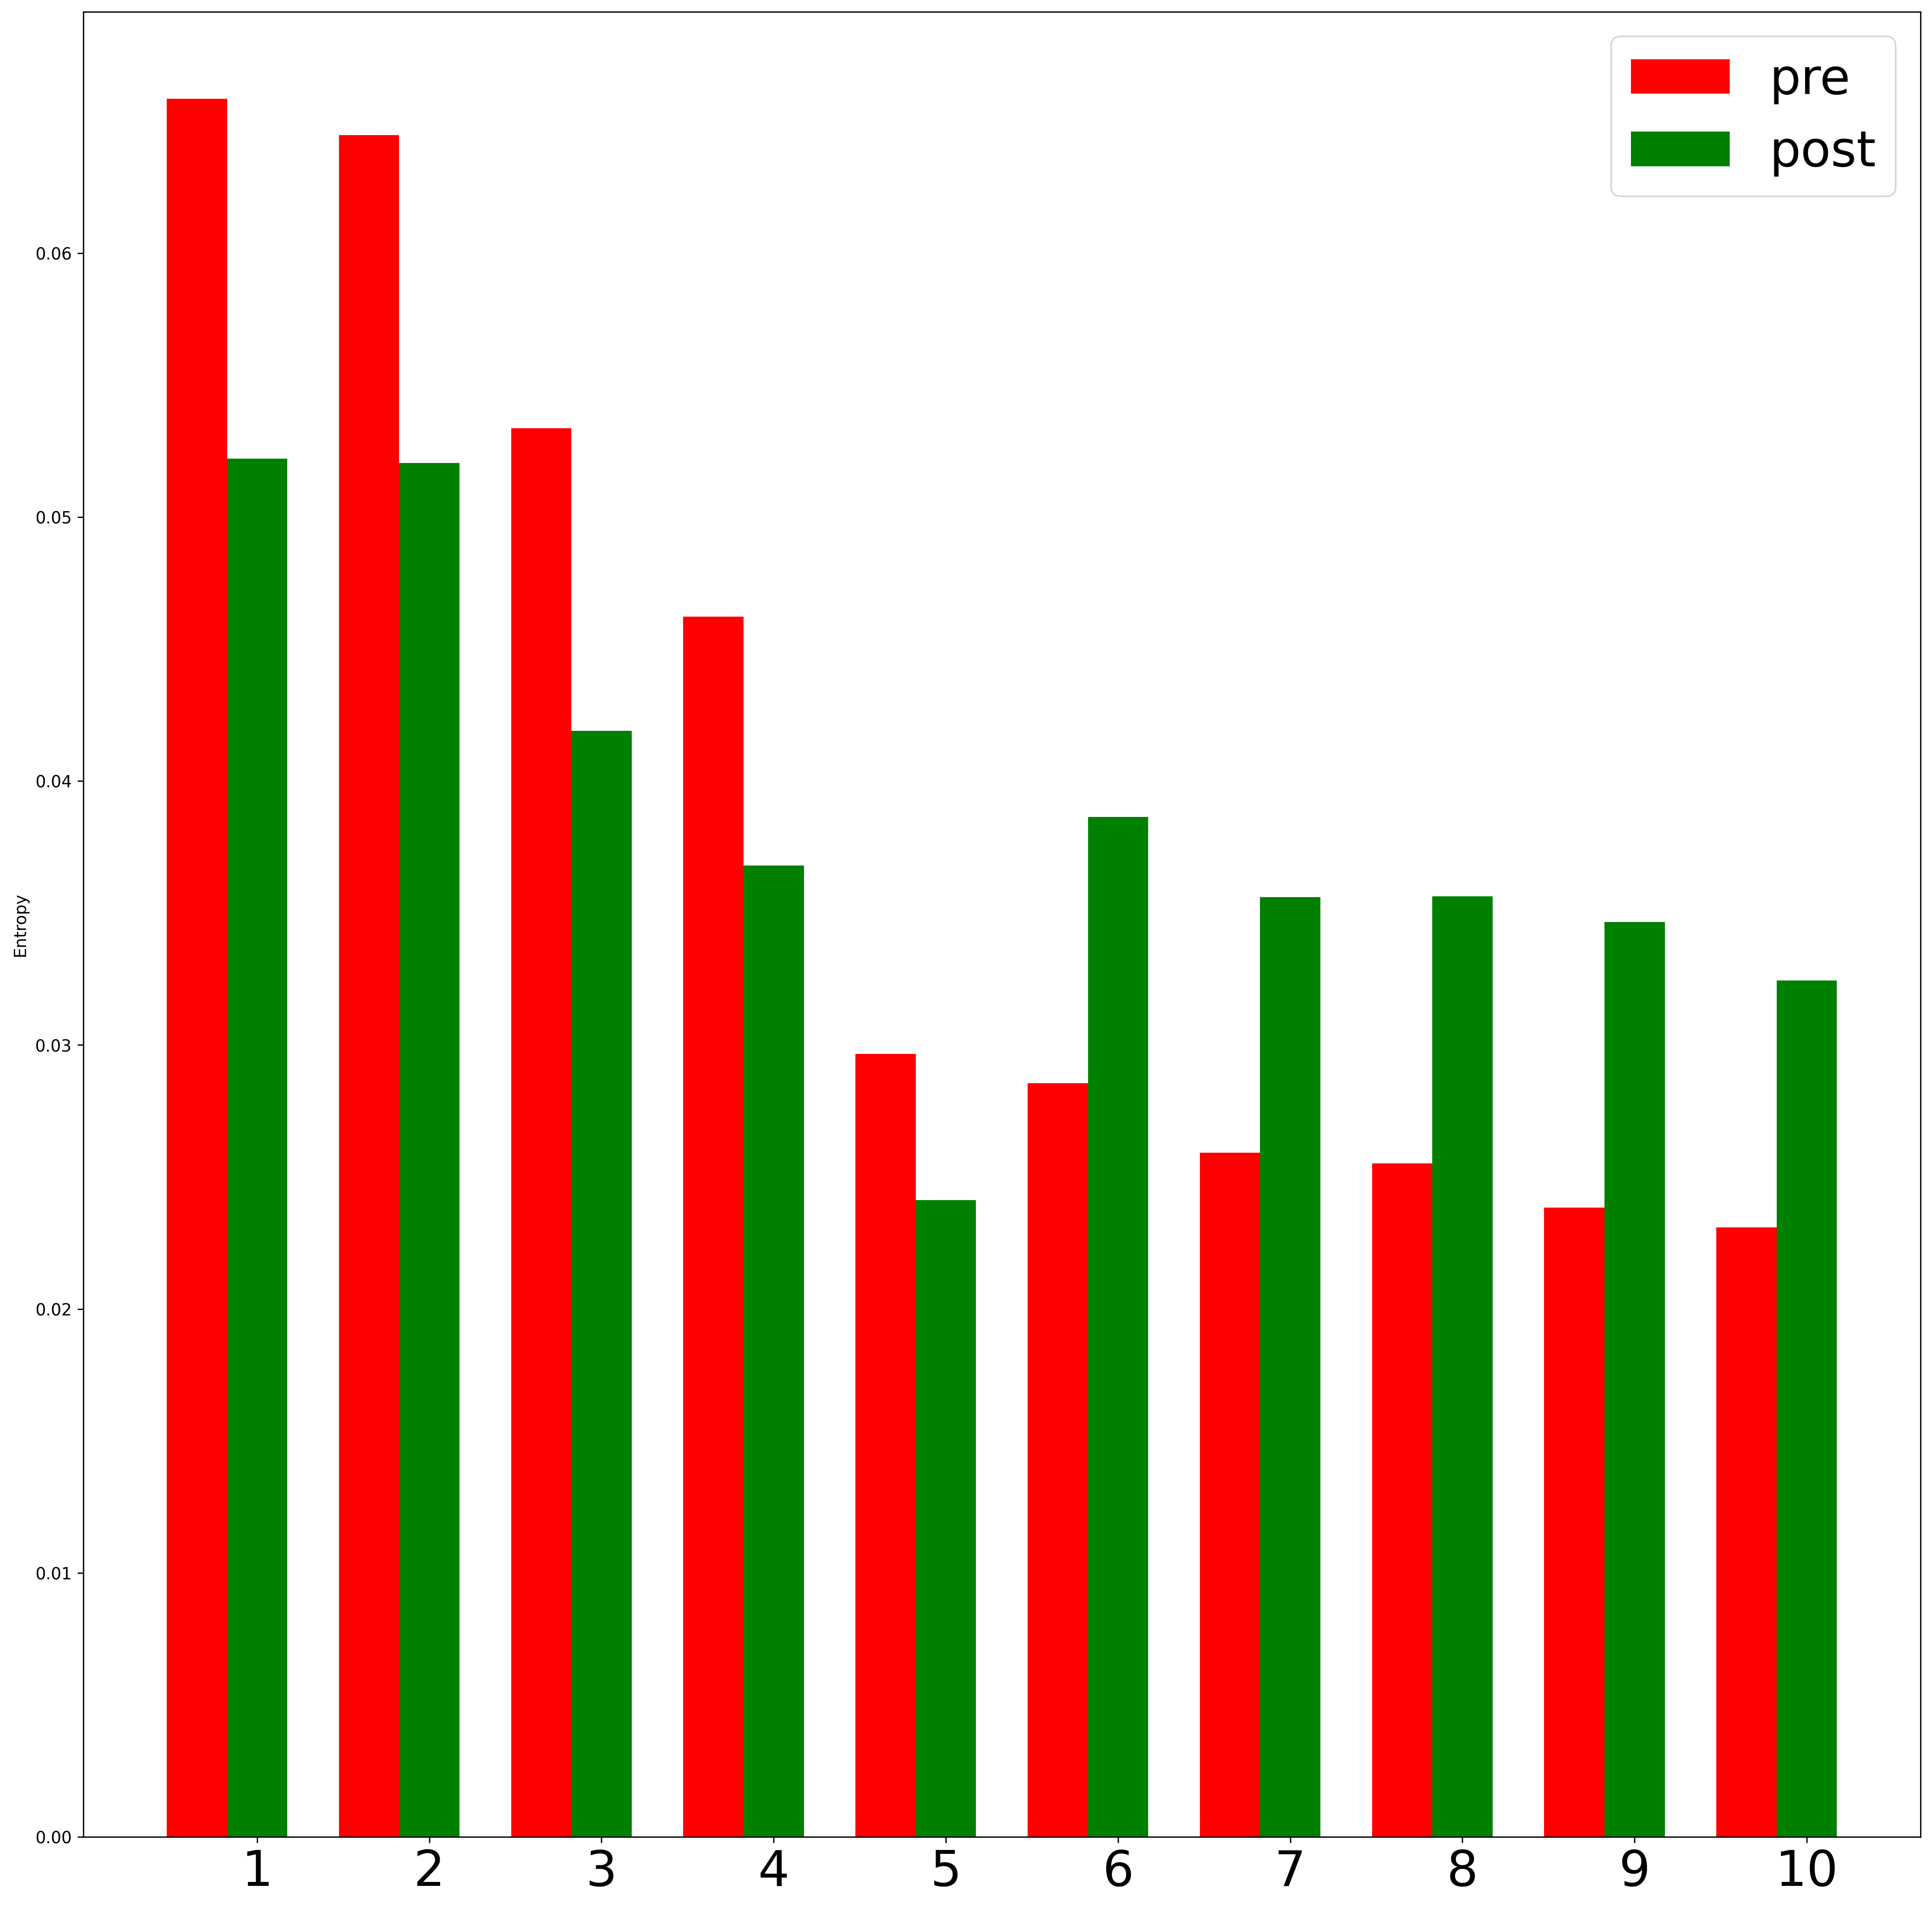

In [98]:
#plt histgram of the entropy of the first 10 microbiomes with each microbiome having two bars g1, g2 so the x-axis will have 10 microbiomes and y-axis will have the entropy value

categories = [f"{i}" for i in range(1,11)]
N = len(categories)
ind = np.arange(N)
width = 0.35
fig = plt.figure()

ax = fig.add_subplot(111)
fig.set_size_inches(20, 20)
g1_mean=g1_normalized[:,:10].mean(axis=0)
g2_mean=g2_normalized[:,:10].mean(axis=0)


rects1 = ax.bar(ind, g1_mean, width, color='r')
rects2 = ax.bar(ind+width, g2_mean, width, color='g')
ax.set_ylabel('Entropy')
ax.set_xticks(ind+width)
#xlbael fontzie larger
plt.xticks(fontsize=30)
ax.set_xticklabels(categories)
ax.legend( (rects1[0], rects2[0]), ('pre', 'post') ,fontsize=30)
plt.show()


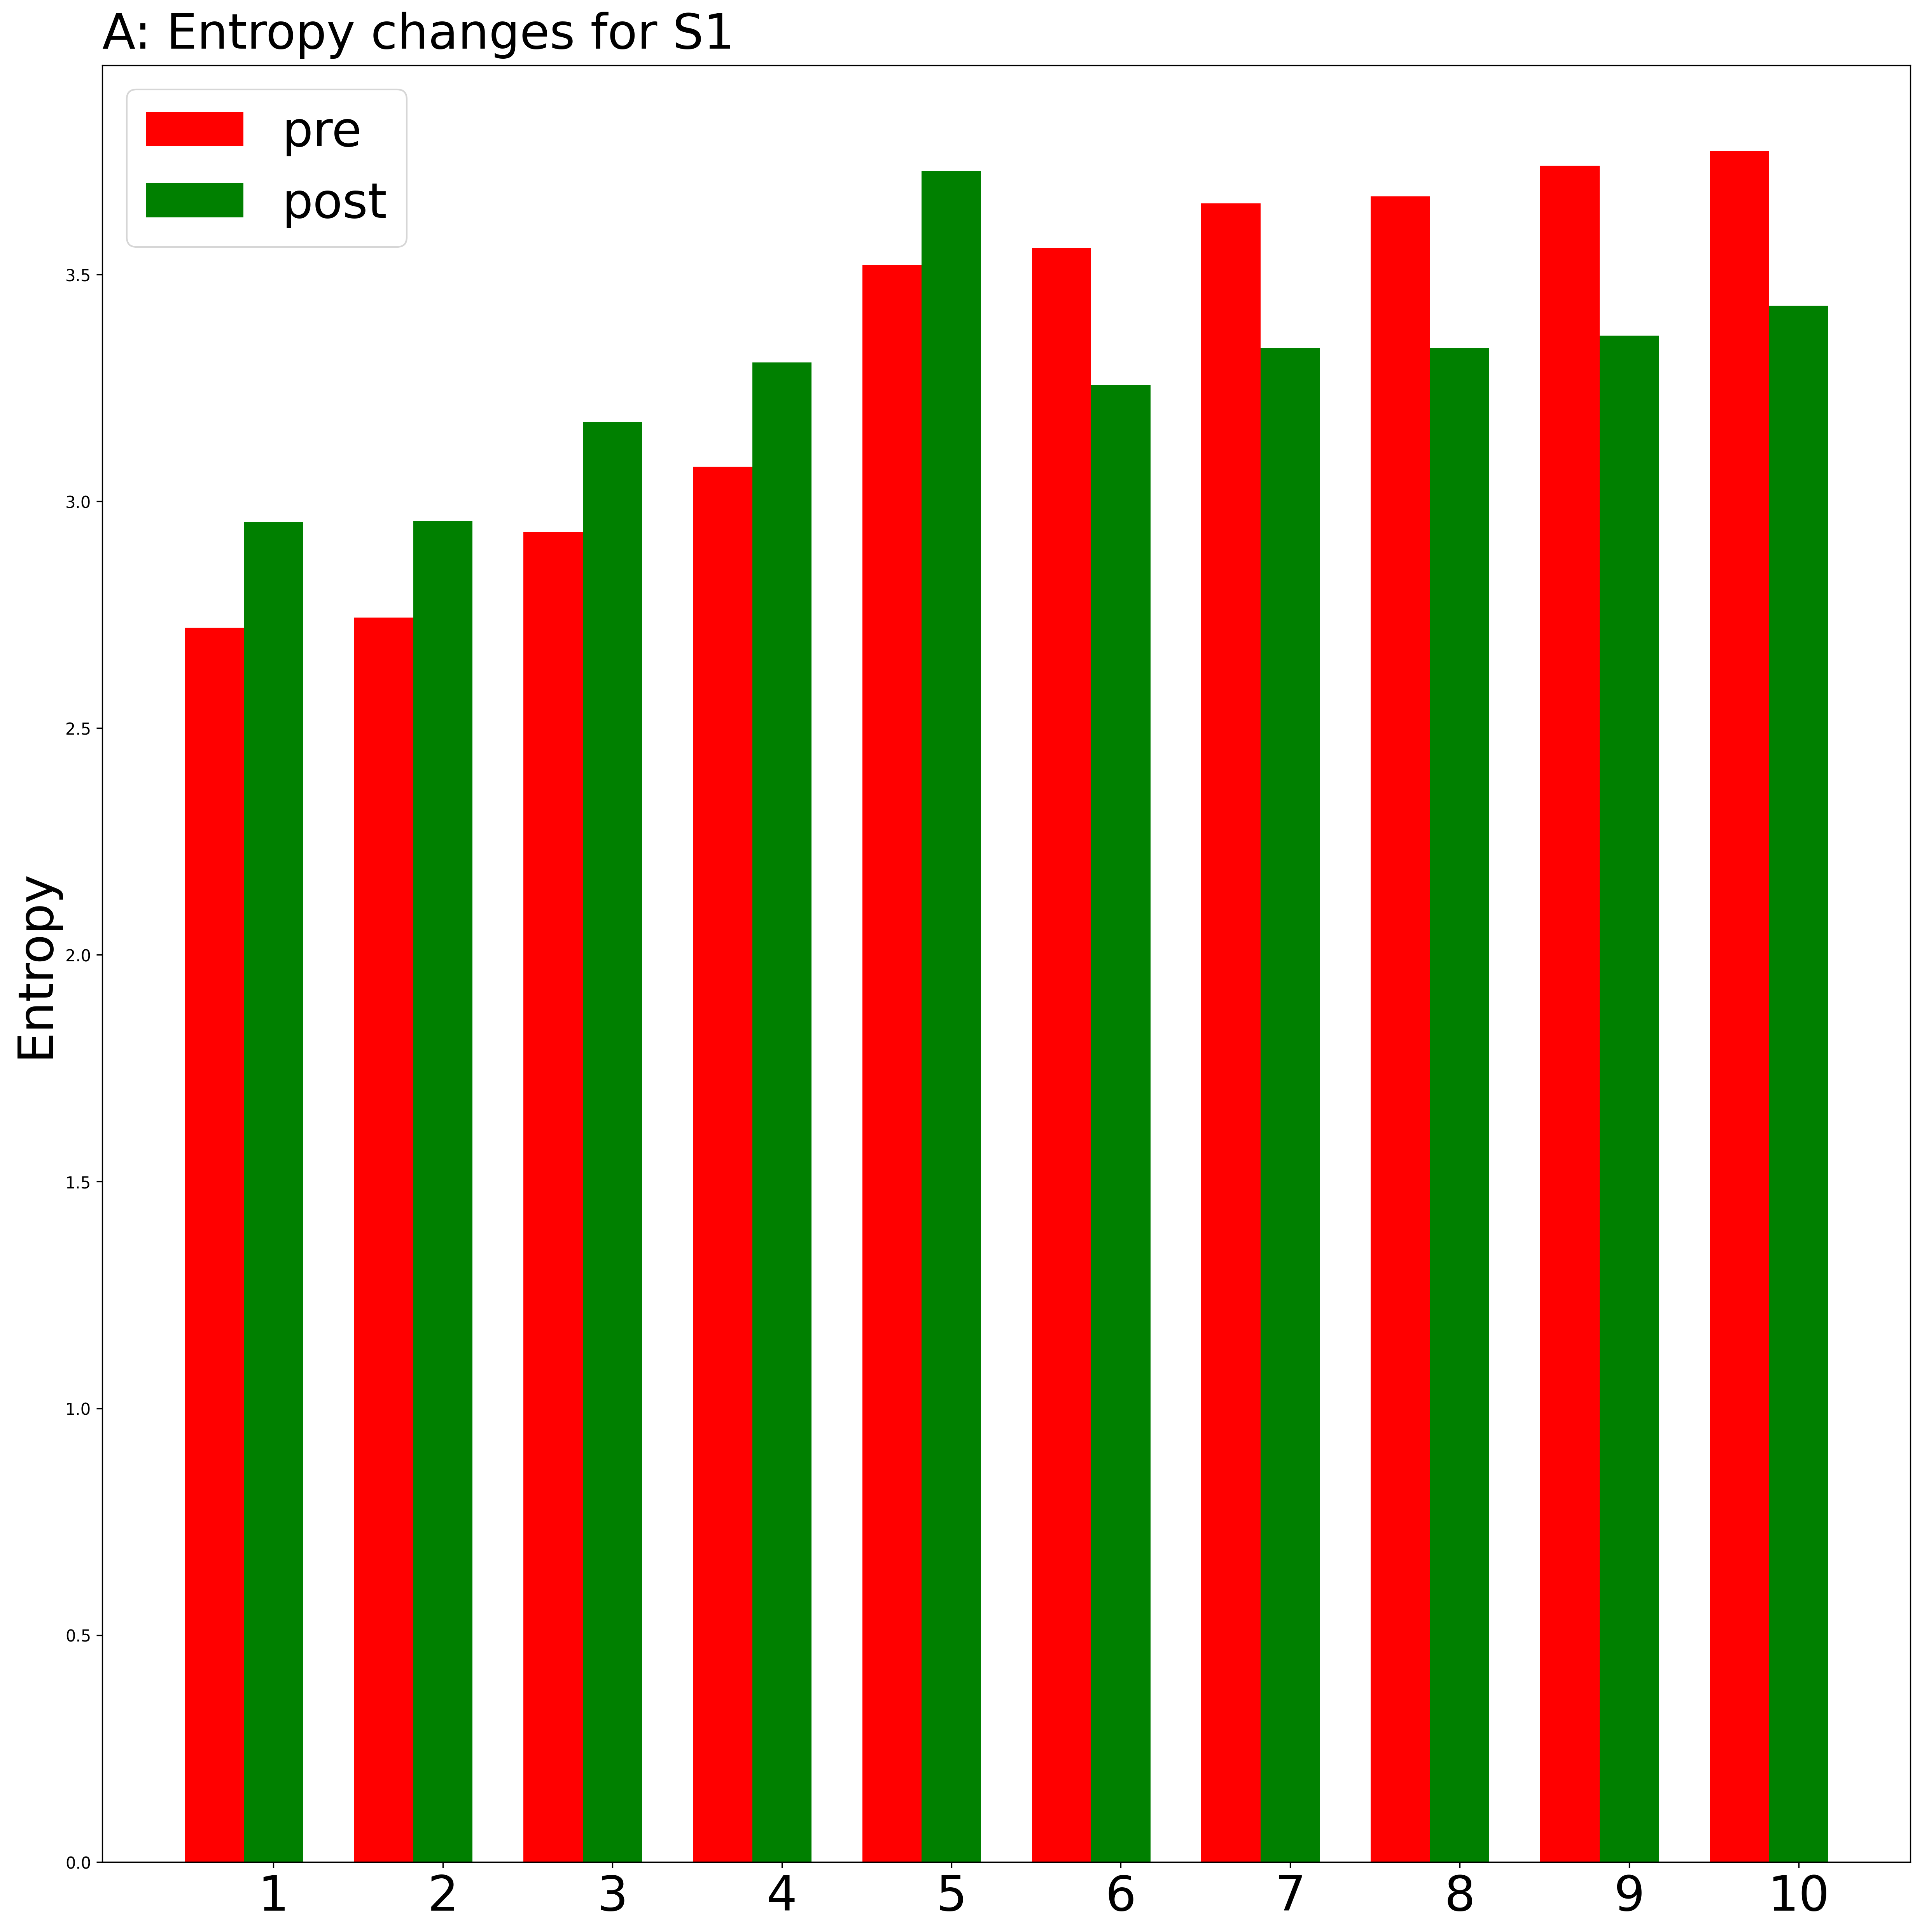

In [99]:
#plt histgram of the entropy of the first 10 microbiomes with each microbiome having two bars g1, g2 so the x-axis will have 10 microbiomes and y-axis will have the entropy value

categories = [f"{i}" for i in range(1,11)]
N = len(categories)
ind = np.arange(N)
width = 0.35
fig = plt.figure()
fig.set_size_inches(20, 20)
ax = fig.add_subplot(111)
g1_mean=g1_entropy[:10,:].mean(axis=1)
g2_mean=g2_entropy[:10,:].mean(axis=1)
rects1 = ax.bar(ind, g1_mean, width, color='r')
rects2 = ax.bar(ind+width, g2_mean, width, color='g')


#dpi 300

ax.set_ylabel('Entropy',fontsize=30)
ax.set_xticks(ind+width)
ax.set_xticklabels(categories)
plt.xticks(fontsize=30)
ax.text(0.0,1.03,f"A: Entropy changes for S1",horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,fontsize=30)
ax.legend( (rects1[0], rects2[0]), ('pre', 'post'), fontsize=30 )
plt.show()
plt.rcParams['figure.dpi'] = 300


## KDE Fitting, p-vlaue

In [100]:
#g1
from src.Grouping import Groupinfo
x_grid=np.arange(0,20,0.1)
feat_info=np.zeros(10)
feat_info+=1.1 ## as this is simulated  case, you cannot consider the prior-posterior case. 

t1=Groupinfo(g1_entropy[0:10,:])
t1.finddistribution(x_grid,epsilon=0.0001,feat_info=feat_info)
t1pos,t1eva=t1.summation(x_grid)

In [101]:
g1
from src.Grouping import Groupinfo
x_grid=np.arange(0,20,0.1)
feat_info=np.zeros(10)
feat_info+=1.1 ## as this is simulated  case, you cannot consider the prior-posterior case. 

t2=Groupinfo(g2_entropy[0:10,:])
t2.finddistribution(x_grid,epsilon=0.0001,feat_info=feat_info)
t2pos,t2eva=t2.summation(x_grid)


In [102]:
# fig = plt.figure()
# fig.set_size_inches(20, 20)
# ax = fig.add_subplot(111)
# g1_mean=g1_entropy[:10,:].mean(axis=1)
# g2_mean=g2_entropy[:10,:].mean(axis=1)
# rects1 = ax.bar(ind, g1_mean, width, color='r')
# rects2 = ax.bar(ind+width, g2_mean, width, color='g')


# #dpi 300

# ax.set_ylabel('Entropy',fontsize=30)
# ax.set_xticks(ind+width)
# ax.set_xticklabels(categories)
# plt.xticks(fontsize=30)
# ax.text(0.0,1.03,f"A: Entropy changes for S1",horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,fontsize=30)
# ax.legend( (rects1[0], rects2[0]), ('pre', 'post'), fontsize=30 )

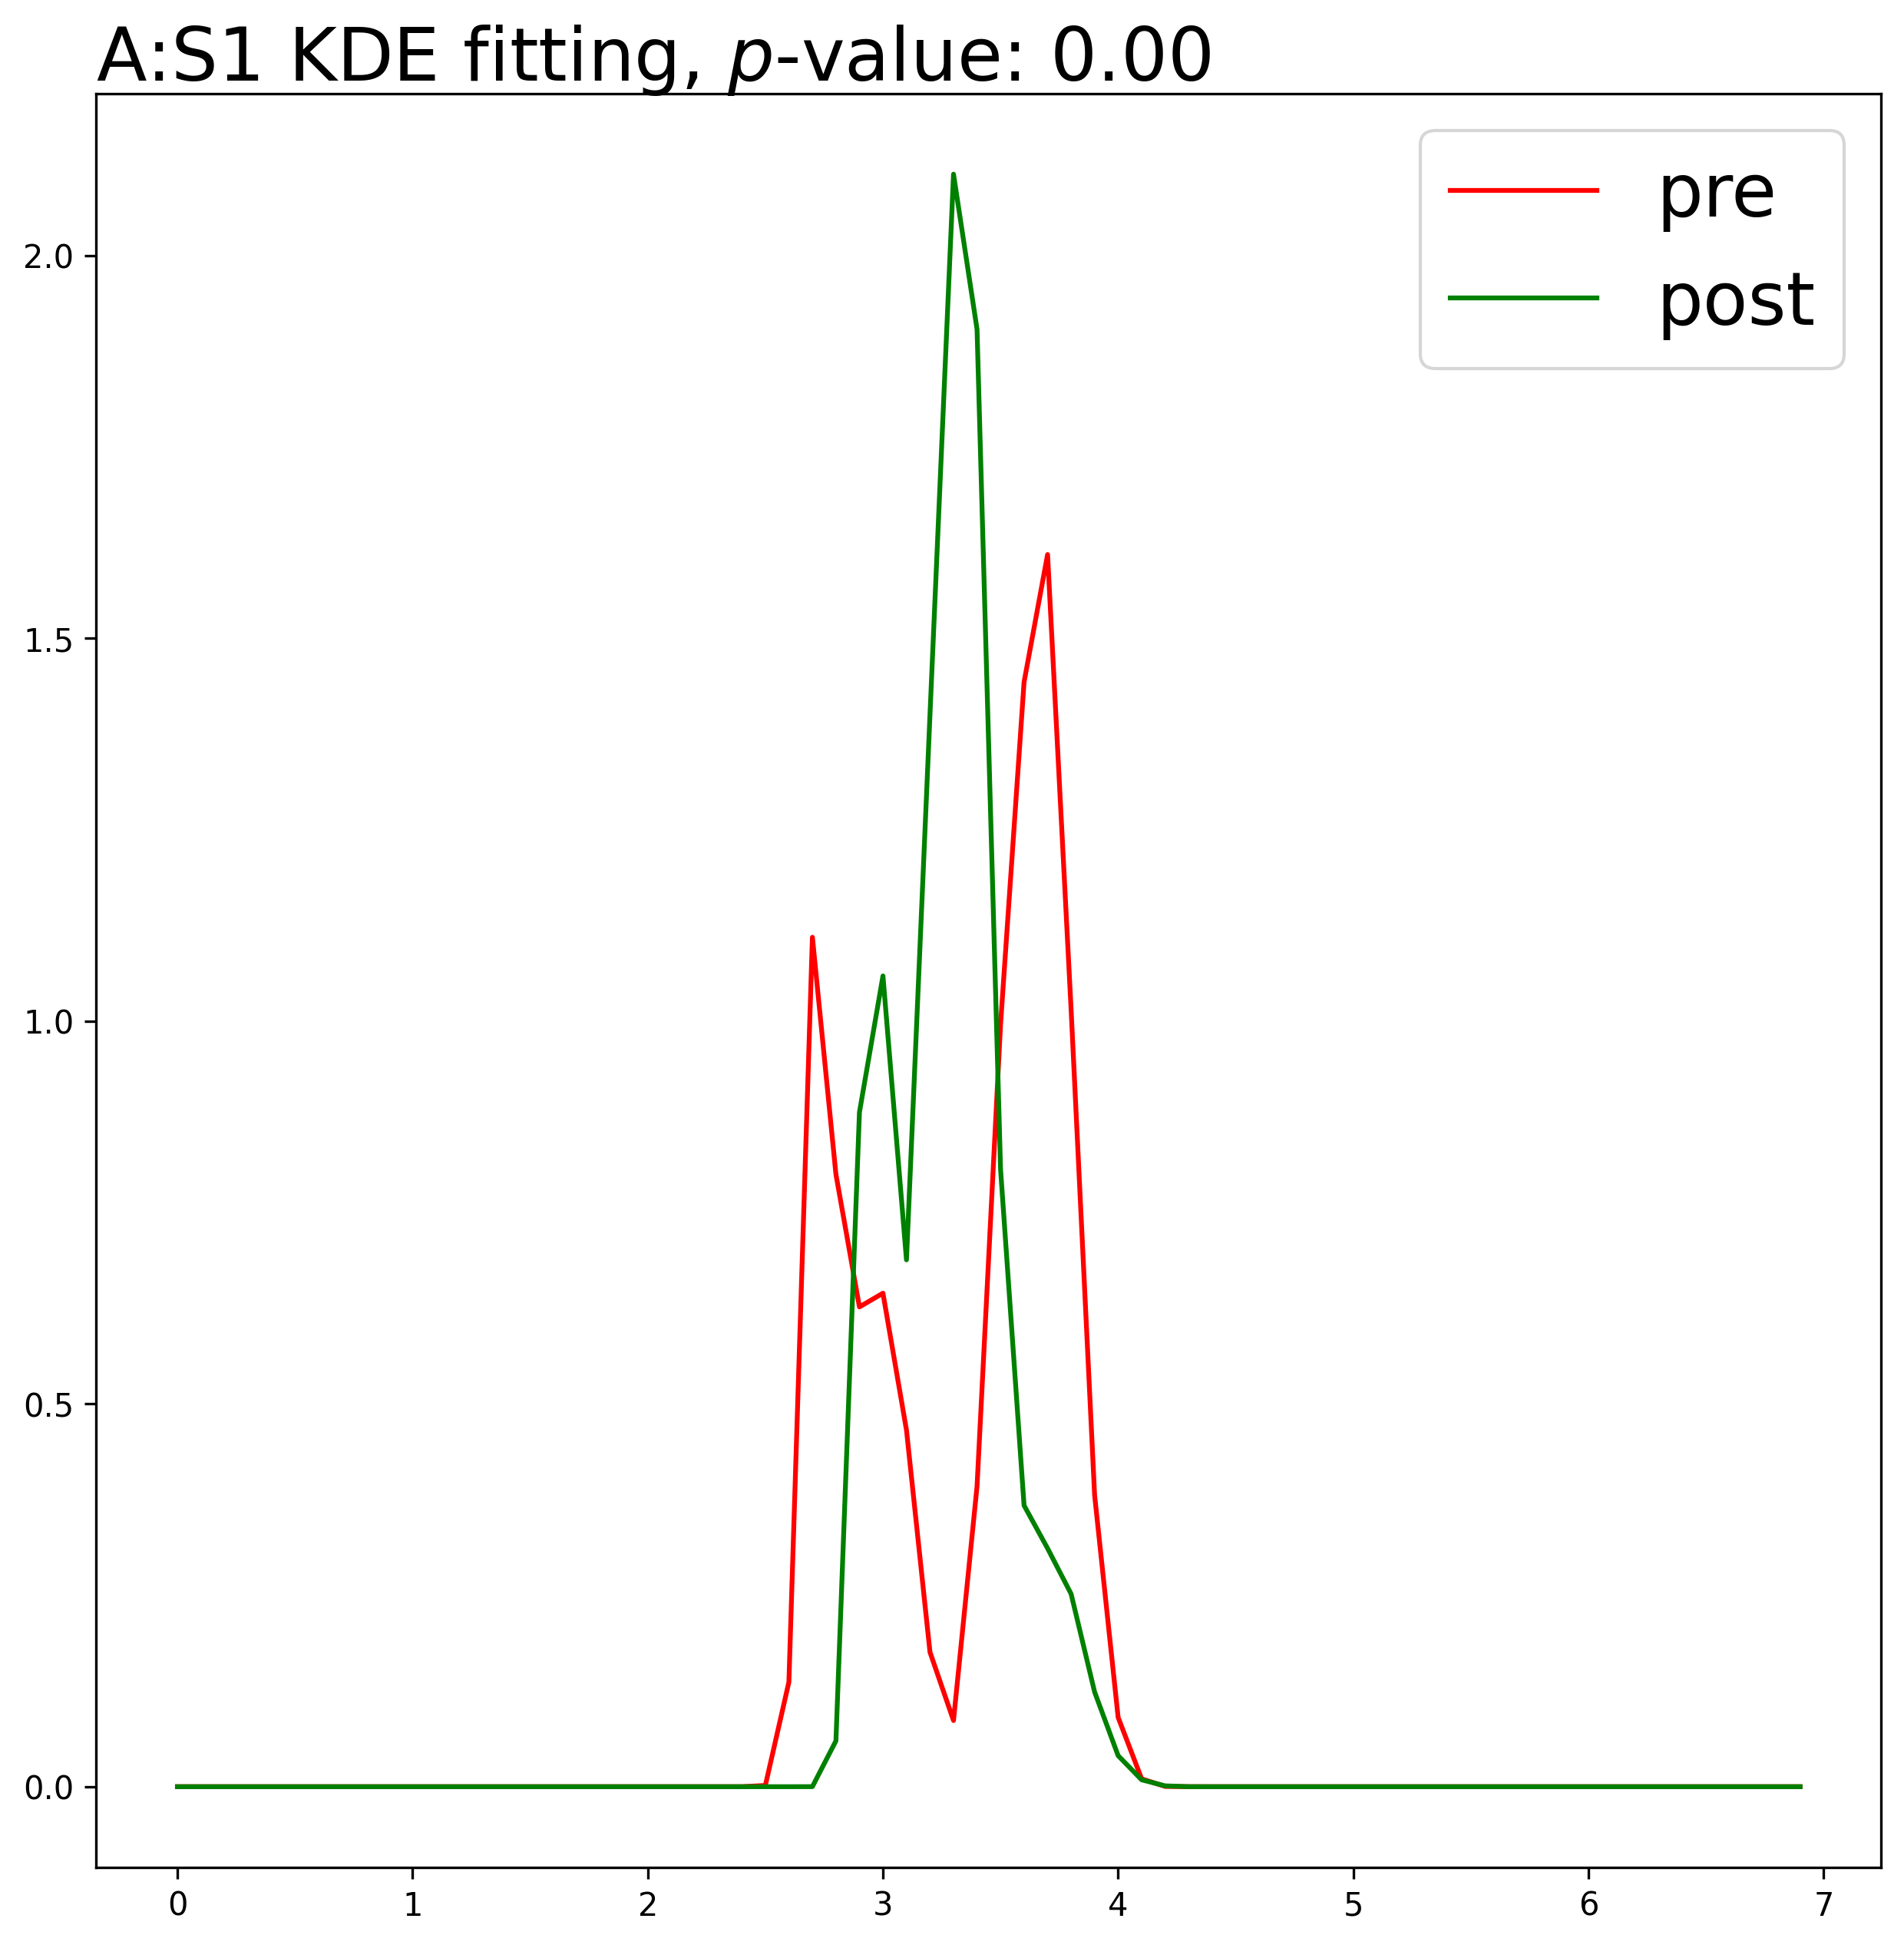

In [104]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.plot(x_grid[:70],t1eva[:70],label='pre',color='r')
ax.plot(x_grid[:70],t2eva[:70],label='post',color='g')
ax.text(-0.0,1.04,r"A:S1 KDE fitting, $p$-value: 0.00",horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,fontsize=23)
ax.legend(fontsize=23)
# the reported p-value was 0.0 for the first 10 microbiomes please add the legend
#set figur
# plt.figure(figsize=(0,20))
# plt.plot(x_grid[:50],t1eva[:50],label='g1',color='r')
# plt.plot(x_grid[:50],t2eva[:50],label='g2',color='g')
# # the reported p-value was 0.0 for the first 10 microbiomes please add the legend
# #set figure size
# plt.rcParams['figure.dpi'] = 300


# #set figure size

# plt.text(-0.0,0.97,f"A: Entropy changes for S1",horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,fontsize=20)
# plt.legend()

## top 100 ~200 histogram.

In [88]:
seed_everything(seed)

beta=0.8

# randomly select the number of microiomes to change the ratio
num_microbiomes_to_change=200
# sort

start_idx=100
end_idx=200
sort_option=True



otu=pd.read_csv("../../Example/Meta_Analysis_Example/throat_otu.csv")

# drop the first column
otu=otu.drop(columns=['Unnamed: 0'])

#dive each row by sum of the row
otu=otu.div(otu.sum(axis=1), axis=0)


ratio=otu.mean()

#print(c)

#otu['x']
# drop three most abundant species

#sort 
# otu=otu.sort_values(by='x',ascending=False)
# #otu=otu.iloc[3:]

#sort ratio
ratio=ratio.sort_values(ascending=False)
ratio=ratio.iloc[3:]

# # divide by sum of the row
# ratio=otu['x']/otu['x'].sum()

#
# randomly select the microbiomes to change the ratio
ratio=ratio.to_numpy()
#ratio=np.random.dirichlet(ratio*100000,size=1)[0]
if sort_option ==False:
    # sort ratio
    np.random.shuffle(ratio)


#theta_1=0.000002 # overdispersion parameter
#num_samples=100 # number of samples.  this will be a major paramter. 

#ratio=np.random.dirichlet(ratio*10000,size=1)[0]

import copy

ratio_fixed_1=copy.deepcopy(ratio[:start_idx])
ratio_to_change=copy.deepcopy(ratio[start_idx:end_idx])
#ratio_to_change
ratio_fixed_2=copy.deepcopy(ratio[end_idx:])

decreased=ratio_to_change[:int(len(ratio_to_change)/2)]-ratio_to_change[:int(len(ratio_to_change)/2)]*beta

ratio_change_first_half=ratio_to_change[:int(len(ratio_to_change)/2)]-decreased
ratio_second_half=copy.deepcopy(ratio_to_change[int(len(ratio_to_change)/2):])
increased=np.zeros(len(ratio_second_half))
sum_ratio_second_half=ratio_second_half.sum()   

for i in range(len(ratio_second_half)):

    additive=(decreased.sum()*0.5)/len(ratio_second_half)
    proportion=(decreased.sum()*0.5)*ratio_second_half[i]/sum_ratio_second_half
    increased[i]=additive+proportion

# distribute the increased ratio to the second half with equivalent to 

ratio_second_half=ratio_second_half+increased

g1_param=copy.deepcopy(ratio)
g_first_half=np.concatenate((ratio_fixed_1,ratio_change_first_half,ratio_second_half))
g2_param=np.concatenate((g_first_half,ratio_fixed_2))


theta_2=0.0001 # overdispersion parameter


# g1_param=g1_param+1e-10
# g2_param=g2_param+1e-10

g1=np.random.dirichlet(g1_param*(1/theta_2),size=args.num_samples)
g2=np.random.dirichlet(g2_param*(1/theta_2), size=args.num_samples)
# s
#create count poisson
g1_count_total=np.zeros(args.num_samples)
g2_count_total=np.zeros(args.num_samples)
#print(g1_count_total)

#what i watn to do is get dividing rowwise summation
# g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
# g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]
g1_count=np.zeros((args.num_samples,len(g1_param)))
g2_count=np.zeros((args.num_samples,len(g1_param)))
g1_count_df=pd.DataFrame(g1_count)
g2_count_df=pd.DataFrame(g2_count)


#randomly create integer from 2000 to 10000 with the number of samples
sample_counts=np.random.randint(10000,15000,args.num_samples)
#sample_counts=np.random.poisson(10000,args.num_samples)

for i in range(args.num_samples):
    g1_count_total[i]=np.random.poisson(sample_counts[i])
    g2_count_total[i]=np.random.poisson(sample_counts[i])
    #rand1=np.random.randint(8000,10000)
    #rand2=np.random.randint(8000,10000)
    #g1_count_total[i]=np.random.randint(10000,15000)
    #g2_count_total[i]=np.random.randint(10000,15000)


for i in range(args.num_samples):
    g1_count[i]=np.random.multinomial(g1_count_total[i],g1[i])
    g2_count[i]=np.random.multinomial(g2_count_total[i],g2[i])


#g1_count_df['group']='g1'
#g2_count_df['group']='g2'
df=pd.concat([g1_count_df,g2_count_df])



df=df.reset_index(drop=True)
filename=f"S1_start_idx_{start_idx}_end_idx_{end_idx}_num_samples_{args.num_samples}_theta_{theta_2}_beta_{beta}.csv"
#filename=f"S1{end_idx-start_idx}_p_num_{args.p_num}_seed{seed}_beta{beta}.csv"
df.to_csv(filename,index=False)


g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]


#create dataframe with g1_normalized and g2_normalized
# concatenate g1_normalized and g2_normalized
# please make into single dataframe with new column indexing group number

g1_normalized_df=pd.DataFrame(g1_normalized)
g2_normalized_df=pd.DataFrame(g2_normalized)

# g1_normalized_df['group']=1
# g2_normalized_df['group']=2

# df=pd.concat([g1_normalized_df,g2_normalized_df])
# df=df.reset_index(drop=True)
# df.to_csv("Example/Meta_Analysis_Example/simulated_data_09.csv",index=False)

epsilon = 1e-10  # Small constant to avoid log(0)
g1_entropy = np.where(g1_normalized > 0.0, -np.log(g1_normalized ), 0)
g2_entropy = np.where(g2_normalized > 0.0, -np.log(g2_normalized ), 0)

g1_entropy = g1_entropy.T
g2_entropy = g2_entropy.T
#drop columns where all values are zero
g1_zero_columns=np.where(~g1_entropy.any(axis=1))[0]
g2_zero_columns=np.where(~g2_entropy.any(axis=1))[0]
#combine two column index
zero_columns=np.concatenate((g1_zero_columns,g2_zero_columns))
g1_entropy=np.delete(g1_entropy,zero_columns,axis=0)
g2_entropy=np.delete(g2_entropy,zero_columns,axis=0)

/tmp/ipykernel_3627900/1953147425.py:157: RuntimeWarning: divide by zero encountered in log
  g1_entropy = np.where(g1_normalized > 0.0, -np.log(g1_normalized ), 0)
/tmp/ipykernel_3627900/1953147425.py:158: RuntimeWarning: divide by zero encountered in log
  g2_entropy = np.where(g2_normalized > 0.0, -np.log(g2_normalized ), 0)


## probability

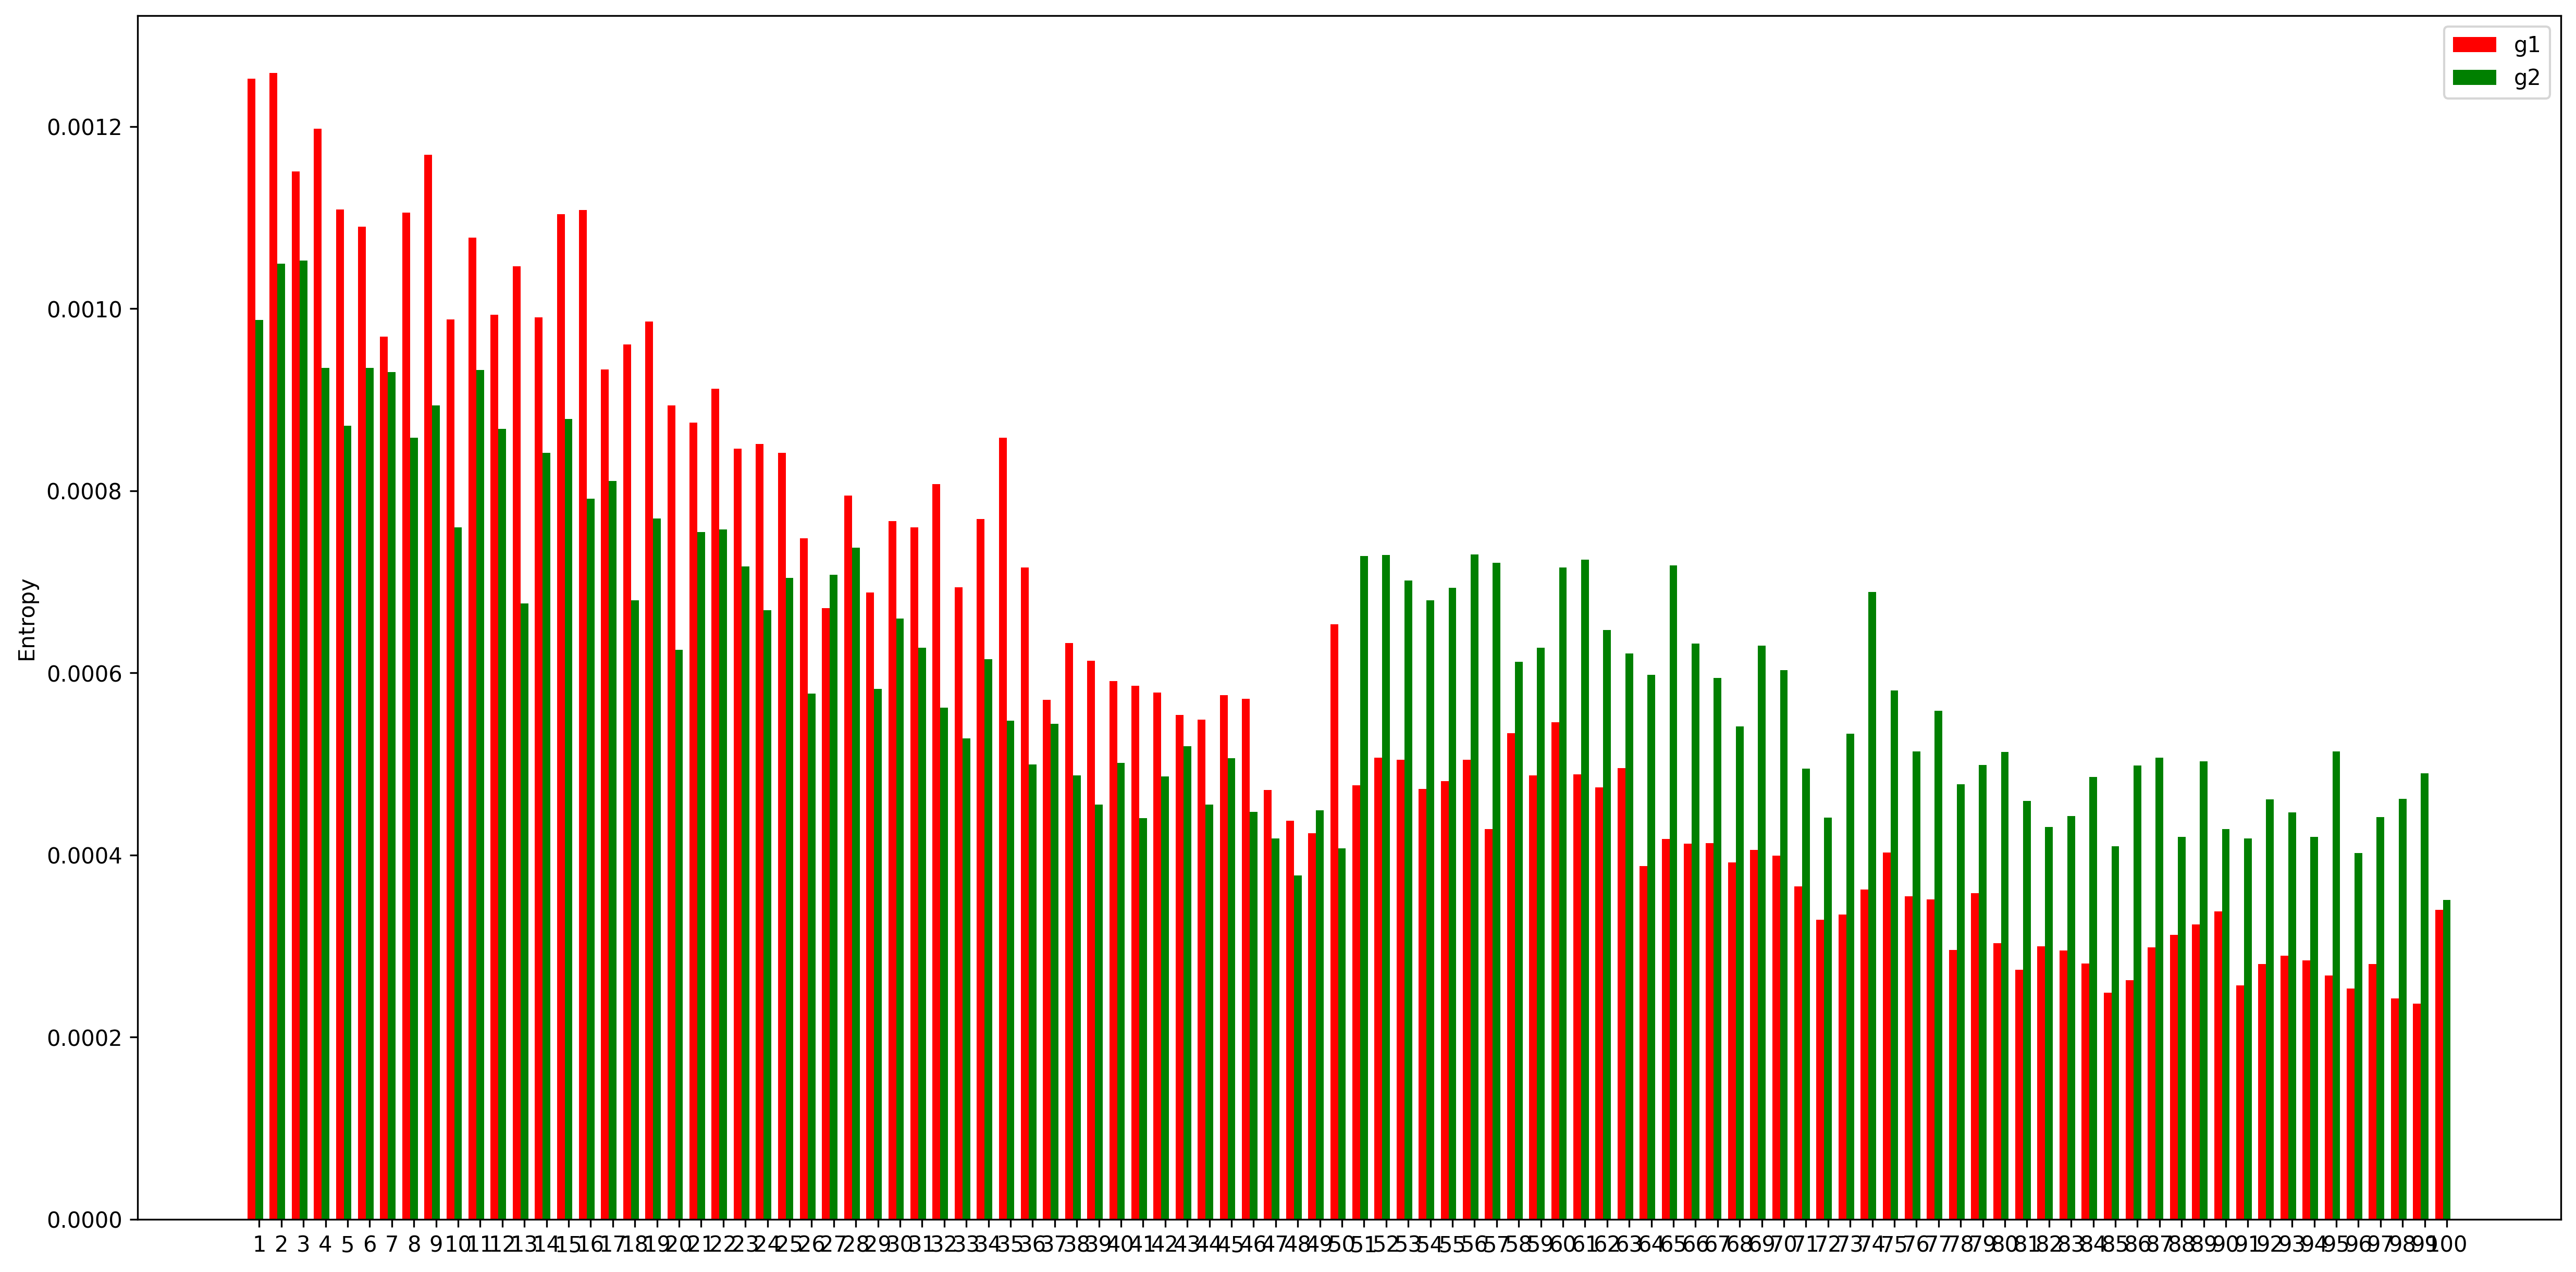

In [89]:
#plt histgram of the entropy of the first 10 microbiomes with each microbiome having two bars g1, g2 so the x-axis will have 10 microbiomes and y-axis will have the entropy value

categories = [f"{i}" for i in range(1,101)]
N = len(categories)
ind = np.arange(N)
width = 0.35
fig = plt.figure()
#size of the figure largely
fig.set_size_inches(20, 10)

ax = fig.add_subplot(111)
g1_mean=g1_normalized[:,100:200].mean(axis=0)
g2_mean=g2_normalized[:,100:200].mean(axis=0)


rects1 = ax.bar(ind, g1_mean, width, color='r')
rects2 = ax.bar(ind+width, g2_mean, width, color='g')
ax.set_ylabel('Entropy')
ax.set_xticks(ind+width)
ax.set_xticklabels(categories)
ax.legend( (rects1[0], rects2[0]), ('g1', 'g2') )
plt.show()


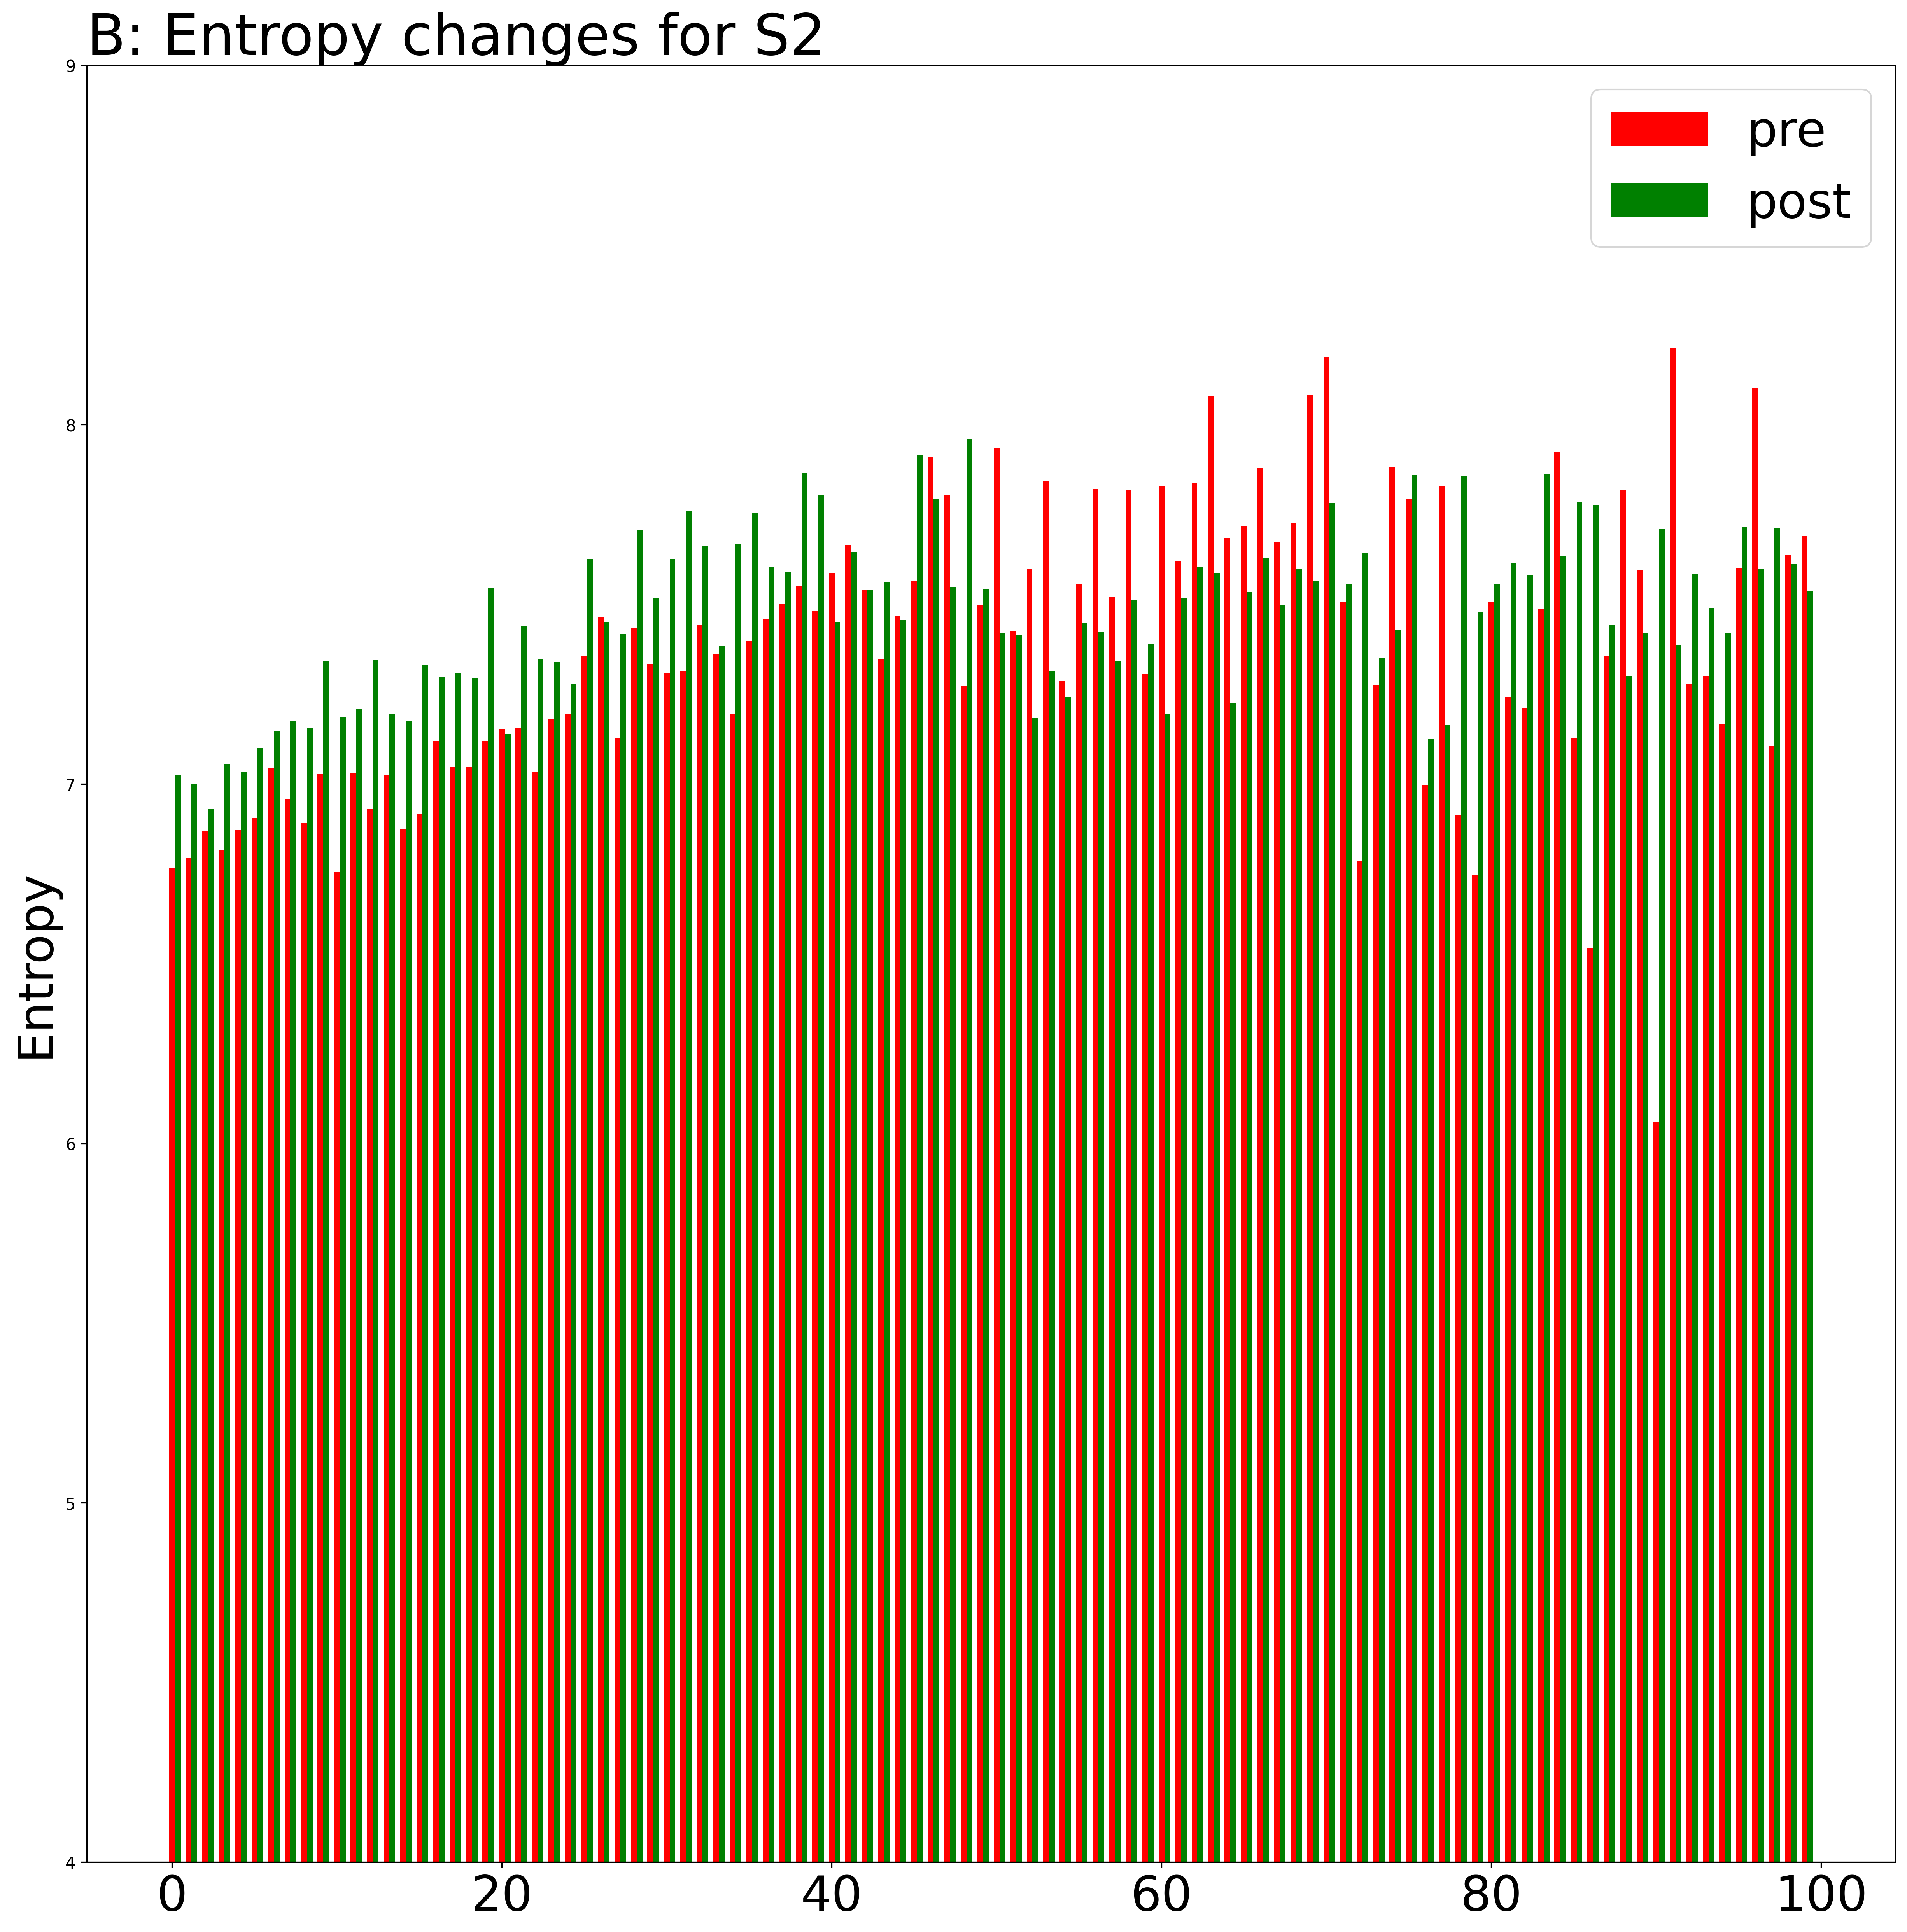

<Figure size 1920x1440 with 0 Axes>

In [90]:
#plt histgram of the entropy of the first 10 microbiomes with each microbiome having two bars g1, g2 so the x-axis will have 10 microbiomes and y-axis will have the entropy value


categories = [f"{i}" for i in range(1,101)]
N = len(categories)
ind = np.arange(N)
width = 0.35
fig = plt.figure()
#size of the figure largely
fig.set_size_inches(20, 20)

ax = fig.add_subplot(111)
g1_mean=g1_entropy[100:200,:].mean(axis=1)
g2_mean=g2_entropy[100:200,:].mean(axis=1)
rects1 = ax.bar(ind, g1_mean, width, color='r',label='g1')
rects2 = ax.bar(ind+width, g2_mean, width, color='g',label='g2')
ax.set_ylabel('Entropy',fontsize=30)
ax.text(0.0,1.03,f"B: Entropy changes for S2",horizontalalignment='left',verticalalignment='top',transform=ax.transAxes,fontsize=35)
#xlabel size larger
ax.tick_params(axis='x', labelsize=30)
#ax.set_xticks(ind+width)
#ax.set_xticklabels(categories)
ax.set_ylim(4.0,9)
ax.legend( (rects1[0], rects2[0]), ('pre', 'post'),fontsize=30 )
plt.show()
plt.savefig("S2_Entropy.png",dpi=300)



In [91]:
#g1
from src.Grouping import Groupinfo
x_grid=np.arange(0,20,0.1)
feat_info=np.zeros(100)
feat_info+=1.1 ## as this is simulated  case, you cannot consider the prior-posterior case. 

t1=Groupinfo(g1_entropy[100:200,:])
t1.finddistribution(x_grid,epsilon=0.0001,feat_info=feat_info)
t1pos,t1eva=t1.summation(x_grid)

#g1




In [92]:
from src.Grouping import Groupinfo
x_grid=np.arange(0,20,0.1)
feat_info=np.zeros(100)
feat_info+=1.1 ## as this is simulated  case, you cannot consider the prior-posterior case. 
t2=Groupinfo(g2_entropy[100:200,:])
t2.finddistribution(x_grid,epsilon=0.0001,feat_info=feat_info)
t2pos,t2eva=t2.summation(x_grid)

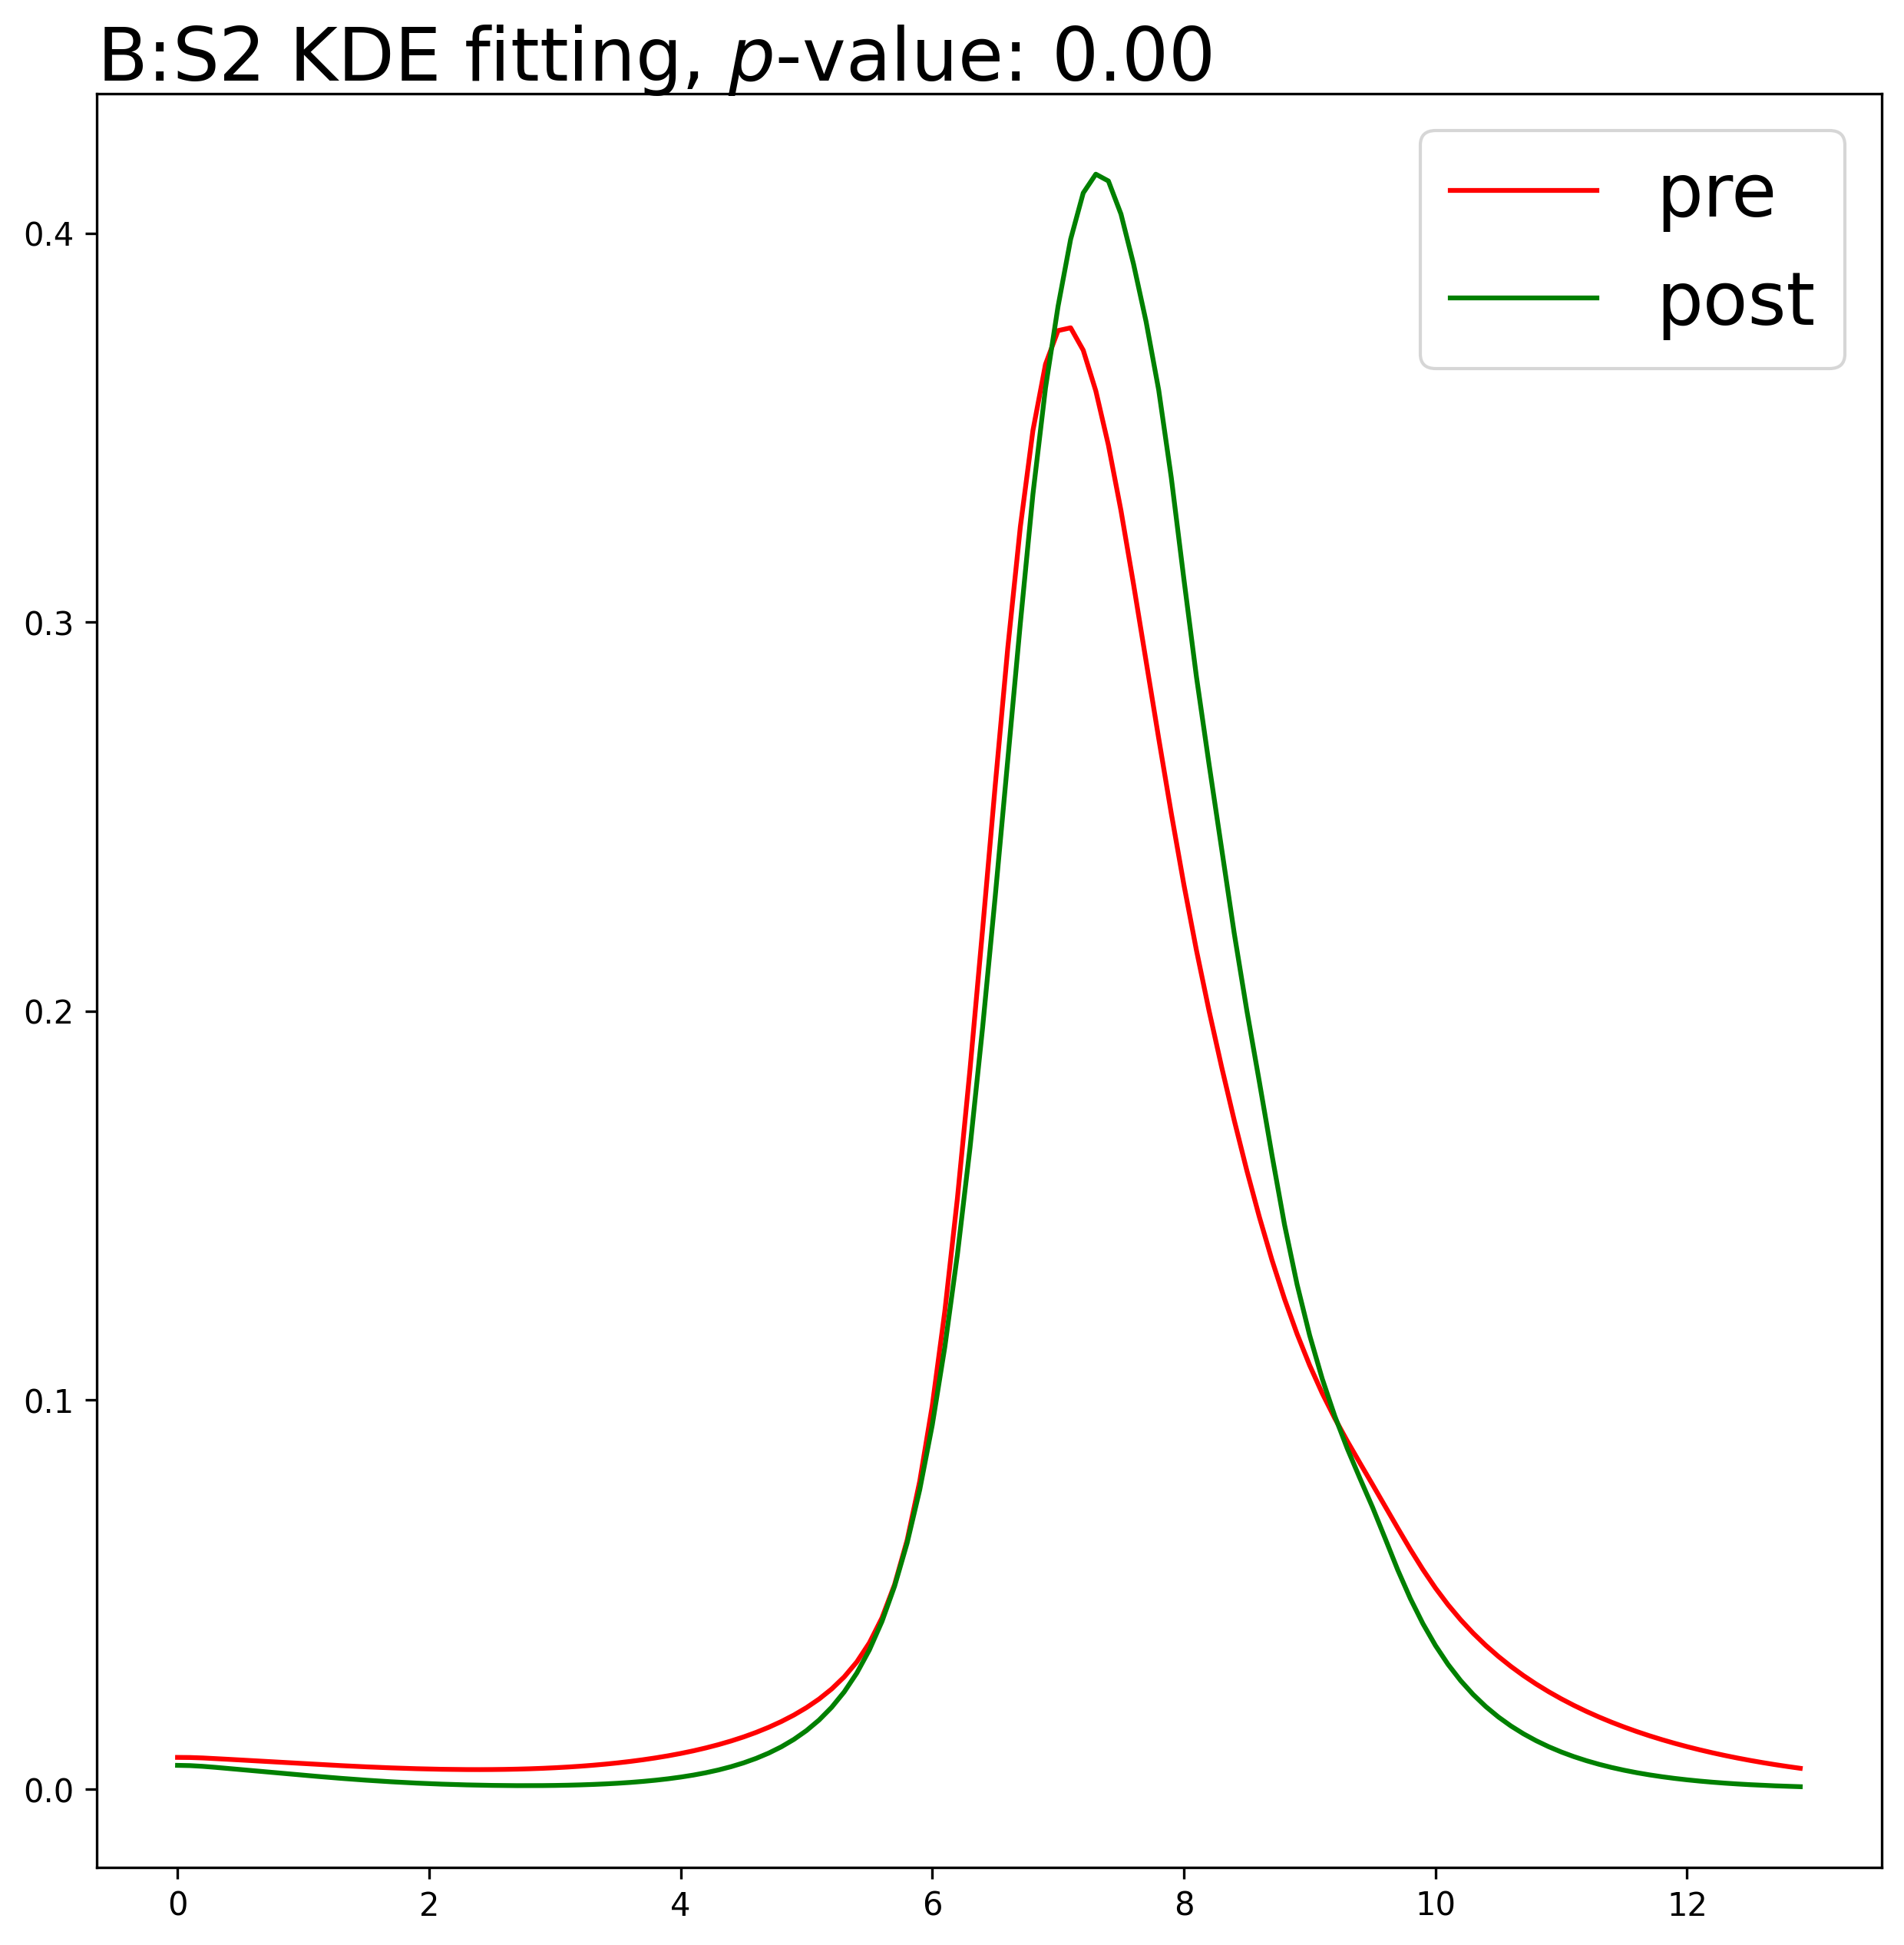

In [93]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.plot(x_grid[:130],t1eva[:130],label='pre',color='r')
ax.plot(x_grid[:130],t2eva[:130],label='post',color='g')
ax.text(-0.0,1.04,r"B:S2 KDE fitting, $p$-value: 0.00",horizontalalignment='left',verticalalignment
='top',transform=ax.transAxes,fontsize=23)
ax.legend(fontsize=23)
#ytitle entropy


#plt.ylabel('Entropy',fontsize=30)
#dpi 300
plt.rcParams['figure.dpi'] = 300

